# **DOMAIN´S CLUSTERING**

- In this notebook I´m going to try and test different clustering models, preprocessing the data in different ways to compare and choose the best results, that is, to find different clusters with similar charasteristics or properties, with the objective of make the advertiser decision of where are the optimal domains to invest easier

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
import pickle
from sklearn.cluster import KMeans, OPTICS, AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics.pairwise import manhattan_distances


from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer, Normalizer

from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score, davies_bouldin_score

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

pd.options.display.float_format = '{:.2f}'.format #So the numbers will not appear in a scientific format

#! pip install pyclustertend
# !pip install pyclustering

In [171]:
groupby_domains = pd.read_csv('DATA/Global groupby_domains.csv')

### IMPORTANT: 
**The proccess that is detailed below has been done with different combinations of variables**.

- First I considered all the variables at once, applying different data preproccesings 
- Second I tested the clustering algorithms several times selecting different combinations of variables, between 6 and 9
- Finally I did that comes next, wich has turned out to be the best choice

****In order to get a better clustering performance, I´m gonna drop the following columns :****

- **Domain:** it´s a string and doesn´t add nothing to the model
- **Category:** I could convert the Categories into numbers, but this can strongly affect to the model, and the categories are also represented in the Category importance columns
- **Viewability Rate, Efficiency Rate:** these columns are important to the advertisers (that´s the reason I didn´t drop them in the first place) but both of them have really high percentages for most of Domains, so they are not useful to find differences between them
- **Clicks**: It has a strong correlation with the Impressions variable, and it´s represented in the CTR (Clicks/Impressions)
- **'Format Loads', 'Impressions'**: ***After repeating this whole proccess with different variables, I decided to keep for this clustering only the variables represented by percentages, in order to have the date with similar scales. It has proven that if I take the Format Loads and Impressions variable, the models are distorted because of it´s large scale, although I applied transformation to the data as MinMax, Standard or Robust scalers***

In [4]:
groupby_domains['Geographical zone importance'] = groupby_domains['Geographical zone'].copy()
groupby_domains['Geographical zone importance'] = (groupby_domains['Geographical zone'].replace('South America', 53.27 )
                                       .replace('West Europe', 11.98 ).replace('East Europe', 10.43)
                                       .replace('North America', 8.32).replace('Asia', 13.09)
                                       .replace('Africa', 1.10).replace('Arabia', 1.55).replace('Australia', 0.22))

In [5]:
groupby_domains_clustering = groupby_domains.drop(['Domain','Format Loads', 'Impressions', 'Clicks','Category', 'Country',
                                                   'Viewability Rate', 'Efficiency Rate', 'Geographical zone'], 1)

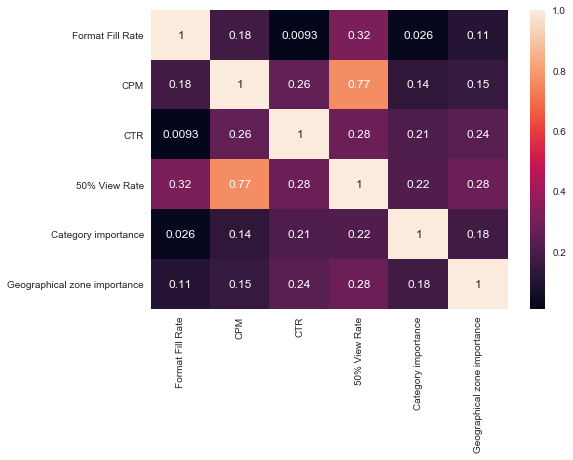

In [6]:
sns.heatmap(groupby_domains_clustering.corr(), annot=True)

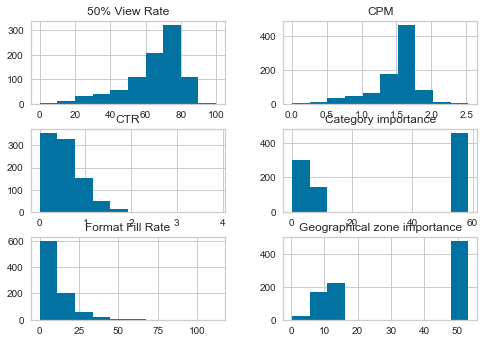

In [7]:
groupby_domains_clustering.hist();

In [8]:
groupby_domains_clustering

,Format Fill Rate,CPM,CTR,50% View Rate,Category importance,Geographical zone importance
0,0.60,1.59,0.46,67.91,2.08,11.98
1,10.81,1.71,0.07,62.05,58.61,8.32
2,3.77,1.44,0.39,68.07,7.63,53.27
3,1.14,1.73,0.40,67.45,58.61,1.10
4,19.54,1.80,0.79,71.88,58.61,13.09
...,...,...,...,...,...,...
896,0.13,1.89,0.10,67.71,58.61,53.27
897,0.20,1.25,0.05,49.28,1.19,8.32
898,13.72,1.70,0.20,69.74,58.61,11.98
899,1.14,1.59,0.00,86.90,0.47,11.98


In [15]:
normalize.shape

(901, 2)

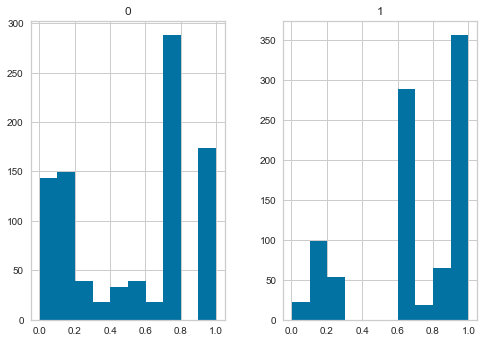

In [11]:
normalize=pd.DataFrame(Normalizer().fit_transform(groupby_domains_clustering[['Category importance', 'Geographical zone importance']]))
normalize.hist();

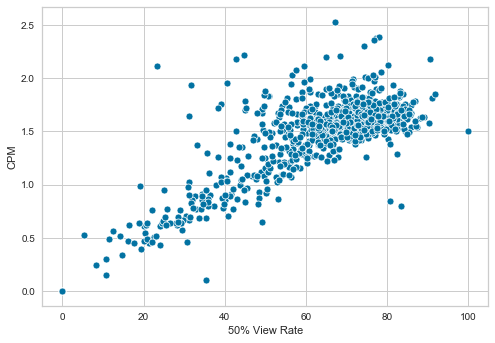

In [6]:
sns.scatterplot(groupby_domains_clustering['50% View Rate'], groupby_domains_clustering['CPM'])

**We see that the variables 50% View Rate and CPM have a strong correlation. It is not recommended to train clustering algorithms with correlated vatriables. I´ll drop 50% View Rate, I consider the CPM variable more important**

In [12]:
groupby_domains_clustering.drop('50% View Rate', 1, inplace = True)

I´m gonna test the clustering over three different data transformations :

- **Standarizing the data with Standard Scaler**
- **Scaling features using statistics that are robust to outliers with Robust Scaler**
- **Transforming features by scaling each feature to a given range (0,1) with MinMax Scaler**

In [13]:
groupby_domains_StandardScaler = StandardScaler().fit_transform(groupby_domains_clustering)
groupby_domains_RobustScaler = RobustScaler().fit_transform(groupby_domains_clustering)
minmax = MinMaxScaler().fit_transform(groupby_domains_clustering)

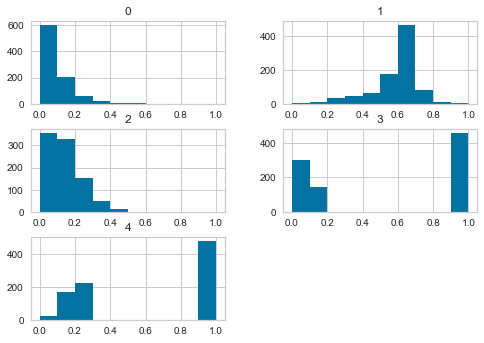

In [14]:
pd.DataFrame(minmax).hist();

In [139]:
groupby_domains.columns

Index(['Domain', 'Format Loads', 'Impressions', 'Format Fill Rate',
       'Viewability Rate', 'Efficiency Rate', 'CPM', 'Clicks', 'CTR',
       '50% View Rate', 'Category', 'Category importance', 'Country',
       'Geographical zone', 'Geographical zone importance'],
      dtype='object')

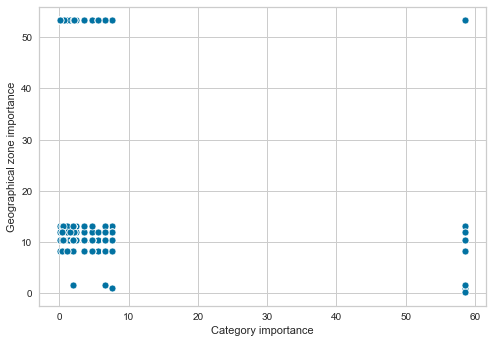

In [141]:
sns.scatterplot(groupby_domains['Category importance'], groupby_domains['Geographical zone importance'] )

### Visual Assessment of cluster Tendency (VAT)

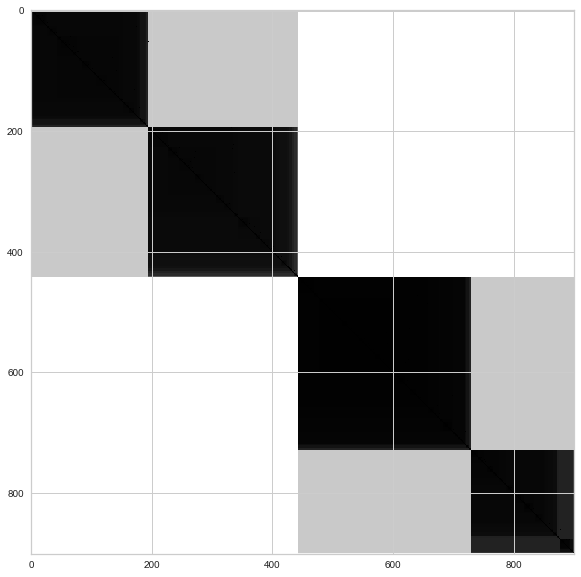

In [99]:
from pyclustertend import ivat
ivat(groupby_domains_clustering)

## Applying GRIDSEARCHCV to find the best parameters for KMEANS ALGORITHM (THIS SECTION HAS TO BE UPDATED WITH THE LATEST VERSION OF THE DATA)

- ### With the Standard Scaler transformation:

In [8]:
kmeans = KMeans()
parameters = {'n_clusters':range(1,15),
              'init' : ('k-means++', 'random'), 
              'n_init':[5,10,15,20,25],
              'max_iter' : [50,100,200,300,400,500,700,1000],
              'algorithm' : ('auto', 'full', 'elkan')}

gridsearchcv_standardscaler = GridSearchCV(estimator = kmeans, param_grid = parameters)

In [10]:
%%time
gridsearchcv_standardscaler.fit(groupby_domains_StandardScaler)

Wall time: 42min 47s


GridSearchCV(cv=None, error_score=nan,
             estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++',
                              max_iter=300, n_clusters=8, n_init=10,
                              n_jobs=None, precompute_distances='auto',
                              random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'algorithm': ('auto', 'full', 'elkan'),
                         'init': ('k-means++', 'random'),
                         'max_iter': [50, 100, 200, 300, 400, 500, 700, 1000],
                         'n_clusters': range(1, 15),
                         'n_init': [5, 10, 15, 20, 25]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [12]:
#Saving the results in a DataFrame
gridsearch_results_SS = pd.DataFrame(gridsearchcv_standardscaler.cv_results_).sort_values(by='rank_test_score')
gridsearch_results_SS.to_csv('GridSearch Standard Scaler Results.csv')
gridsearch_results_SS.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_init,param_max_iter,param_n_clusters,param_n_init,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3145,0.04,0.00,0.00,0.00,elkan,random,400,14,5,"{'algorithm': 'elkan', 'init': 'random', 'max_...",-1817.66,-527.36,-547.53,-402.67,-441.44,-747.33,537.82,1
1815,0.08,0.01,0.00,0.00,full,random,100,14,5,"{'algorithm': 'full', 'init': 'random', 'max_i...",-2077.53,-493.75,-527.52,-408.41,-485.67,-798.58,640.67,2
3146,0.10,0.00,0.00,0.00,elkan,random,400,14,10,"{'algorithm': 'elkan', 'init': 'random', 'max_...",-2102.65,-454.43,-534.86,-390.99,-510.29,-798.64,653.88,3


In [13]:
# save the model to disk
filename = 'gridsearchmodel_standardscaler.sav'
pickle.dump(gridsearchcv_standardscaler, open(filename, 'wb'))

In [14]:
# load the model from disk
filename = 'gridsearchmodel_standardscaler.sav'
gridsearchmodel_standardscaler = pickle.load(open(filename, 'rb'))


In [15]:
gridsearchmodel_standardscaler.best_estimator_

KMeans(algorithm='elkan', copy_x=True, init='random', max_iter=400,
       n_clusters=14, n_init=5, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

- ### With the Robust Scaler transformation:

In [16]:
kmeans = KMeans()
parameters = {'n_clusters':range(1,17),
              'init' : ('k-means++', 'random'), 
              'n_init':[5,10,15,20,25],
              'max_iter' : [50,100,200,300,400,700,1000],
              'algorithm' : ('auto', 'full', 'elkan')}

gridsearchcv_robustscaler = GridSearchCV(estimator = kmeans, param_grid = parameters)

In [17]:
%%time
gridsearchcv_robustscaler.fit(groupby_domains_RobustScaler)

Wall time: 51min 34s


GridSearchCV(cv=None, error_score=nan,
             estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++',
                              max_iter=300, n_clusters=8, n_init=10,
                              n_jobs=None, precompute_distances='auto',
                              random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'algorithm': ('auto', 'full', 'elkan'),
                         'init': ('k-means++', 'random'),
                         'max_iter': [50, 100, 200, 300, 400, 700, 1000],
                         'n_clusters': range(1, 17),
                         'n_init': [5, 10, 15, 20, 25]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [19]:
#Saving the results in a DataFrame
gridsearch_results_RS = pd.DataFrame(gridsearchcv_robustscaler.cv_results_).sort_values(by='rank_test_score')
gridsearch_results_RS.to_csv('GridSearch Results with Robust Scaler.csv')
gridsearch_results_RS.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_init,param_max_iter,param_n_clusters,param_n_init,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3356,0.12,0.02,0.00,0.00,elkan,random,1000,16,10,"{'algorithm': 'elkan', 'init': 'random', 'max_...",-5372.63,-686.85,-633.02,-462.59,-555.98,-1542.21,1916.70,1
2956,0.19,0.02,0.00,0.00,elkan,random,100,16,10,"{'algorithm': 'elkan', 'init': 'random', 'max_...",-5341.84,-697.44,-665.97,-512.00,-543.19,-1552.09,1896.18,2
1039,0.38,0.04,0.00,0.00,auto,random,700,16,25,"{'algorithm': 'auto', 'init': 'random', 'max_i...",-5346.14,-675.65,-684.13,-519.91,-557.82,-1556.73,1895.79,3


In [20]:
# save the model to disk
filename = 'gridsearchmodel_robustscaler.sav'
pickle.dump(gridsearchcv_robustscaler, open(filename, 'wb'))

In [21]:
# load the model from disk
filename = 'gridsearchmodel_robustscaler.sav'
gridsearchmodel_robustscaler = pickle.load(open(filename, 'rb'))


In [22]:
gridsearchmodel_robustscaler.best_estimator_

KMeans(algorithm='elkan', copy_x=True, init='random', max_iter=1000,
       n_clusters=16, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

- ### With the MinMax Scaler transformation:

In [16]:
kmeans = KMeans()
parameters = {'n_clusters':range(1,17),
              'init' : ('k-means++', 'random'), 
              'n_init':[5,10,15,20,25],
              'max_iter' : [50,100,200,300,400,700,1000],
              'algorithm' : ('auto', 'full', 'elkan')}

gridsearchcv_robustscaler = GridSearchCV(estimator = kmeans, param_grid = parameters)

In [17]:
%%time
gridsearchcv_minmax.fit(minmax)

Wall time: 51min 34s


GridSearchCV(cv=None, error_score=nan,
             estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++',
                              max_iter=300, n_clusters=8, n_init=10,
                              n_jobs=None, precompute_distances='auto',
                              random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'algorithm': ('auto', 'full', 'elkan'),
                         'init': ('k-means++', 'random'),
                         'max_iter': [50, 100, 200, 300, 400, 700, 1000],
                         'n_clusters': range(1, 17),
                         'n_init': [5, 10, 15, 20, 25]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [19]:
#Saving the results in a DataFrame
gridsearch_results_MM = pd.DataFrame(gridsearchcv_minmax.cv_results_).sort_values(by='rank_test_score')
gridsearch_results_MM.to_csv('GridSearch Results with MinMax Scaler.csv')
gridsearch_results_MM.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_init,param_max_iter,param_n_clusters,param_n_init,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3356,0.12,0.02,0.00,0.00,elkan,random,1000,16,10,"{'algorithm': 'elkan', 'init': 'random', 'max_...",-5372.63,-686.85,-633.02,-462.59,-555.98,-1542.21,1916.70,1
2956,0.19,0.02,0.00,0.00,elkan,random,100,16,10,"{'algorithm': 'elkan', 'init': 'random', 'max_...",-5341.84,-697.44,-665.97,-512.00,-543.19,-1552.09,1896.18,2
1039,0.38,0.04,0.00,0.00,auto,random,700,16,25,"{'algorithm': 'auto', 'init': 'random', 'max_i...",-5346.14,-675.65,-684.13,-519.91,-557.82,-1556.73,1895.79,3


In [20]:
# save the model to disk
filename = 'gridsearchmodel_robustscaler.sav'
pickle.dump(gridsearchcv_robustscaler, open(filename, 'wb'))

In [21]:
# load the model from disk
filename = 'gridsearchmodel_robustscaler.sav'
gridsearchmodel_robustscaler = pickle.load(open(filename, 'rb'))


In [22]:
gridsearchmodel_robustscaler.best_estimator_

KMeans(algorithm='elkan', copy_x=True, init='random', max_iter=1000,
       n_clusters=16, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

**I decide not to choose the random init, although it has been chosen as the best init parameter in both scenarios. In some cases, if the initialization of clusters is not appropriate, K-Means can result in arbitrarily bad clusters. This is where K-Means++ helps, because it specifies a procedure to initialize the cluster centers before moving forward with the standard k-means clustering algorithm**

**Using the K-Means++ algorithm, we optimize the step where we randomly pick the cluster centroid, and we are more likely to find a solution that is competitive to the optimal K-Means solution while using the K-Means++ initialization**

Because of that, I´ll choose the best result where with the k-means++ init:

In [19]:
gridsearch_results_RS = pd.read_csv("GridSearch Results with Robust Scaler.csv")
gridsearch_results_SS = pd.read_csv("GridSearch Standard Scaler Results.csv")
display(gridsearch_results_RS[gridsearch_results_RS['param_init']=='k-means++'].head(1))
display(gridsearch_results_RS[gridsearch_results_SS['param_init']=='k-means++'].head(1))

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_init,param_max_iter,param_n_clusters,param_n_init,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,556,0.16,0.01,0.00,0.00,auto,k-means++,1000,16,10,"{'algorithm': 'auto', 'init': 'k-means++', 'ma...",-5363.48,-682.62,-667.99,-592.56,-580.18,-1577.37,1893.49,10


,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_init,param_max_iter,param_n_clusters,param_n_init,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,3350,0.06,0.00,0.00,0.00,elkan,random,1000,15,5,"{'algorithm': 'elkan', 'init': 'random', 'max_...",-5381.67,-690.97,-703.62,-508.84,-577.82,-1572.59,1905.92,8


# KMEANS ALGORITHM

### ELBOW METHOD visualization to check the ideal number of clusters 

In [23]:
def visualization_clusters(data, clustering_model):

    # calinski_harabasz and silhouette scores visualization
    visualizer1 = KElbowVisualizer(
        clustering_model, k=(3,17), metric='calinski_harabasz', timings=False
    )

    visualizer1.fit(data)        # Fit the data to the visualizer
    visualizer1.show()        # Finalize and render the figure

    visualizer2 = KElbowVisualizer(
        clustering_model, k=(3,17), metric='silhouette', timings=False
    )

    visualizer2.fit(data)        # Fit the data to the visualizer
    visualizer2.show()        # Finalize and render the figure
    
    visualizer3 = KElbowVisualizer(
    clustering_model, k=(3,17), metric='distortion', timings=False
    )

    visualizer3.fit(data)        # Fit the data to the visualizer
    visualizer3.show()        # Finalize and render the figure

- ### With the Standard Scaler transformation:

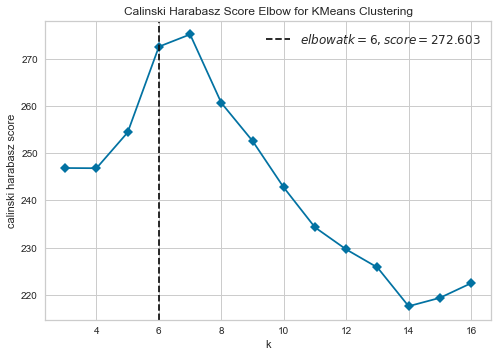

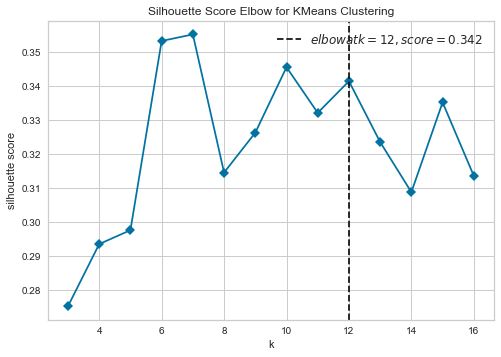

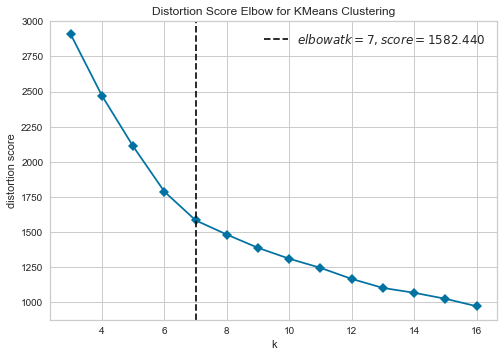

In [24]:
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
visualization_clusters(groupby_domains_StandardScaler, model)

- ### With the Robust Scaler transformation:

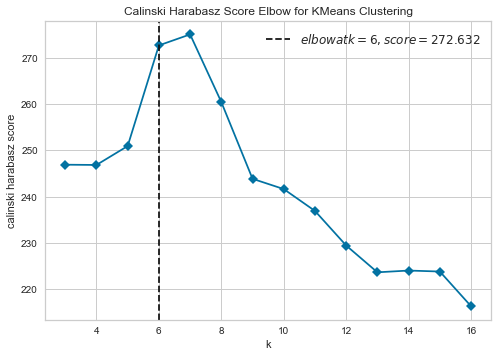

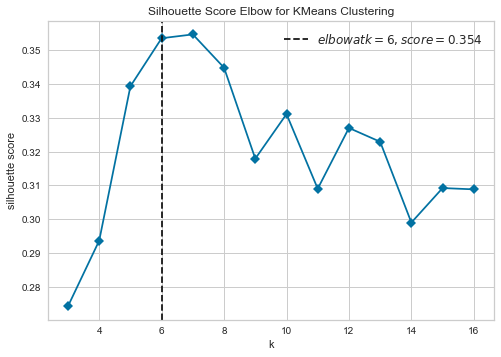

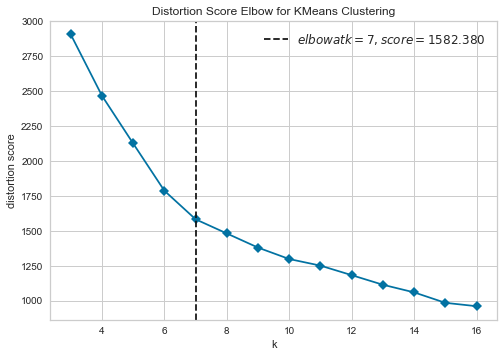

In [25]:
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
visualization_clusters(groupby_domains_StandardScaler, model)

- ### With the MinMax transformation:

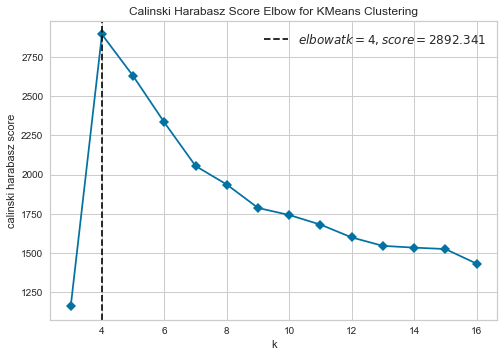

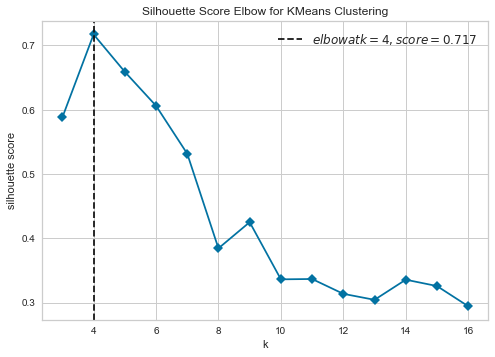

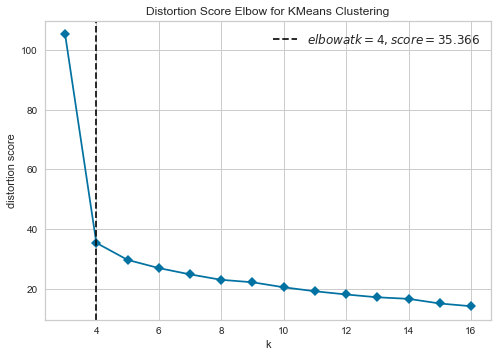

In [26]:
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
visualization_clusters(minmax, model)

- ### With the raw Data :

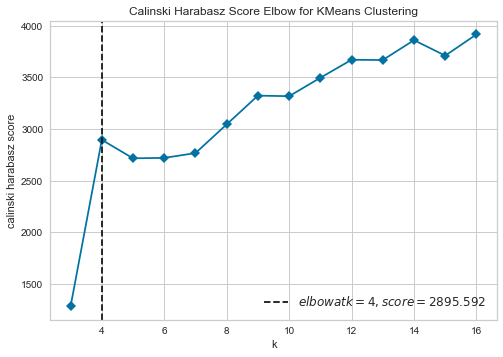

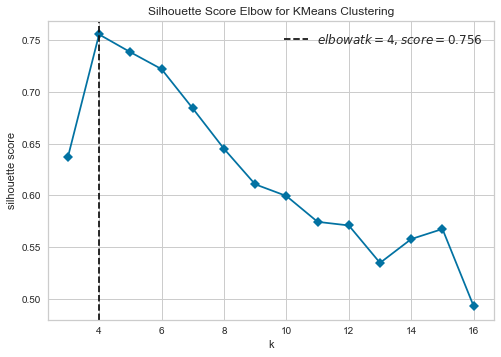

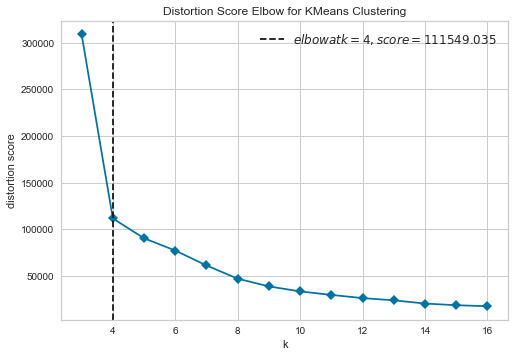

In [27]:
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
visualization_clusters(groupby_domains_clustering, model)

- **My first impression is that, in order to simplify and make the advertiser decision easier, detecting a specific cluster attending to its preferences, the number of clusters should not be more than 10**

- **The GridSearchCV best result for n_clusters is the maximum I defined (14 in the first case, and 16 in the second case). But attending to the Elbow Method I´m gonna train the Kmeans Model with 9 clusters**

### Training the KMEANS model

In [28]:
def results_evaluation(model, data):

    #This function has 2 arguments:
    #-model: to define de Clusters and the scores
    #-data: the data I´m working with, to calculate the scores
  

    print('CLUSTERING DIVISION:\n', pd.DataFrame(model.labels_)[0].value_counts())
    
    new_df = groupby_domains.copy()
    new_df['Cluster'] = model.labels_
    display(new_df.groupby('Cluster').mean())
    
    print('The Silhouette Score is: ', silhouette_score(data, model.labels_, metric='euclidean'))
    print('The Calinski Harabasz Score is: ', calinski_harabasz_score(data, model.labels_))
    print('The Davies Douldin Score is: ', davies_bouldin_score(data, model.labels_))


- ### With the optimal parameters for Standard Scaled Data, based on the GridSearchCV results

In [29]:
kmeans_StandardScaler = KMeans(n_clusters=6, init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
kmeans_StandardScaler.fit(groupby_domains_StandardScaler)
results_evaluation(kmeans_StandardScaler, groupby_domains_StandardScaler)


CLUSTERING DIVISION:
 3    258
4    187
0    162
1    141
2    102
5     51
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Geographical zone importance
Cluster,,,,,,,,,,,
0,114105.77,9941.91,10.96,76.64,88.18,1.56,66.24,0.61,69.49,4.35,53.27
1,160495.81,10448.95,8.46,77.90,89.85,1.59,64.87,0.57,67.45,58.61,10.30
2,80558.29,4735.23,4.60,34.78,41.42,0.70,27.95,0.23,31.11,20.47,22.32
3,120511.98,10593.12,9.05,80.28,88.51,1.59,85.18,0.72,72.19,58.61,53.27
4,120009.29,6607.51,6.97,75.82,88.98,1.60,27.68,0.45,64.28,3.82,11.04
5,128395.33,42370.00,41.47,79.19,93.85,1.66,172.19,0.44,76.26,34.23,36.83


The Silhouette Score is:  0.3525913263839253
The Calinski Harabasz Score is:  272.1816375735593
The Davies Douldin Score is:  1.091866397894279


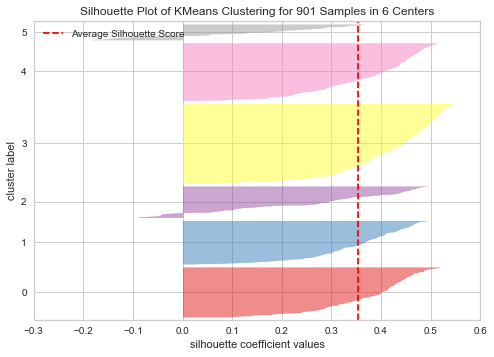

In [30]:
sv = SilhouetteVisualizer(kmeans_StandardScaler)
sv.fit(groupby_domains_StandardScaler)
sv.show()

- ### With the optimal parameters for Robust Scaled Data, based on the GridSearchCV results

In [34]:
kmeans_RobustScaler = KMeans(n_clusters=6, init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
kmeans_RobustScaler.fit(groupby_domains_RobustScaler)
results_evaluation(kmeans_RobustScaler, groupby_domains_RobustScaler)


CLUSTERING DIVISION:
 2    219
5    200
4    178
3    165
1    107
0     32
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Geographical zone importance
Cluster,,,,,,,,,,,
0,130835.80,51571.32,48.01,78.38,92.44,1.65,198.69,0.41,75.63,32.96,32.72
1,80208.18,4856.49,4.86,35.28,42.02,0.71,28.14,0.24,31.76,23.20,23.95
2,129033.36,8686.06,6.77,83.70,91.73,1.64,92.36,1.01,71.08,43.70,42.66
3,163206.26,6728.11,5.09,78.56,90.52,1.77,19.05,0.29,69.00,25.05,19.74
4,115765.65,19072.66,20.32,79.44,94.11,1.60,109.73,0.54,73.88,32.89,40.92
5,104256.66,5595.71,5.98,70.81,81.06,1.39,31.96,0.45,62.78,27.70,32.77


The Silhouette Score is:  0.2259106583268461
The Calinski Harabasz Score is:  312.6247607296839
The Davies Douldin Score is:  1.2549134917968996


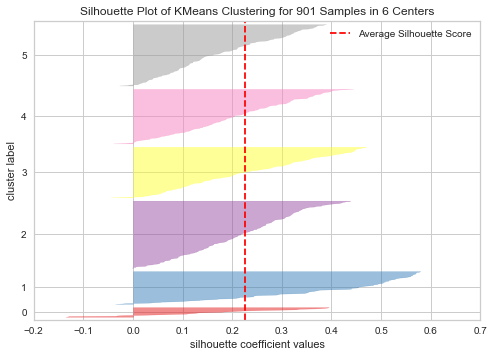

In [35]:
sv = SilhouetteVisualizer(kmeans_RobustScaler)
sv.fit(groupby_domains_RobustScaler)
sv.show()

- ### With the MinMax transformation

In [38]:
kmeans_minmax = KMeans(n_clusters=4, init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
kmeans_minmax.fit(minmax)
results_evaluation(kmeans_minmax, minmax)


CLUSTERING DIVISION:
 0    286
1    249
2    194
3    172
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Geographical zone importance
Cluster,,,,,,,,,,,
0,120915.15,11953.75,10.59,78.76,87.37,1.57,86.98,0.69,71.12,58.61,53.27
1,108567.48,6587.40,8.07,67.24,79.03,1.41,28.42,0.39,57.42,3.81,10.95
2,112384.32,13421.98,12.35,72.54,84.25,1.49,74.47,0.56,66.38,4.36,53.27
3,151141.77,11822.60,10.21,72.89,83.91,1.48,71.30,0.53,63.72,58.61,10.18


The Silhouette Score is:  0.7171556372743594
The Calinski Harabasz Score is:  2892.341465442794
The Davies Douldin Score is:  0.42723166080963476


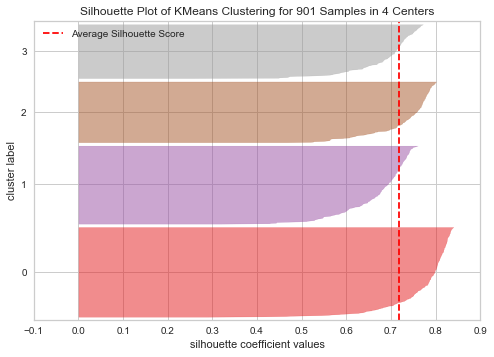

In [39]:
sv = SilhouetteVisualizer(kmeans_minmax)
sv.fit(minmax)
sv.show()

- ### With the raw data

In [41]:
kmeans_raw = KMeans(n_clusters=4, init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
kmeans_raw.fit(groupby_domains_clustering)
results_evaluation(kmeans_raw, groupby_domains_clustering)


CLUSTERING DIVISION:
 0    286
1    249
2    194
3    172
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Geographical zone importance
Cluster,,,,,,,,,,,
0,120915.15,11953.75,10.59,78.76,87.37,1.57,86.98,0.69,71.12,58.61,53.27
1,108567.48,6587.40,8.07,67.24,79.03,1.41,28.42,0.39,57.42,3.81,10.95
2,112384.32,13421.98,12.35,72.54,84.25,1.49,74.47,0.56,66.38,4.36,53.27
3,151141.77,11822.60,10.21,72.89,83.91,1.48,71.30,0.53,63.72,58.61,10.18


The Silhouette Score is:  0.7557272728843112
The Calinski Harabasz Score is:  2895.5916125736658
The Davies Douldin Score is:  0.390265901336067


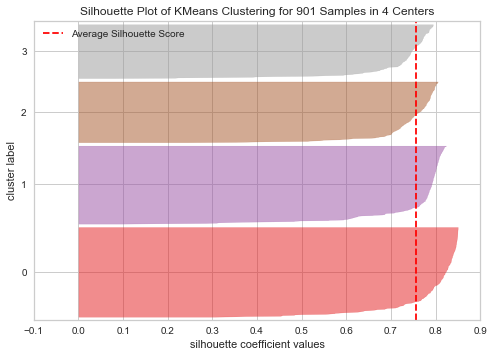

In [42]:
sv = SilhouetteVisualizer(kmeans_raw)
sv.fit(groupby_domains_clustering)
sv.show()

## HIERARCHICAL CLUSTERING

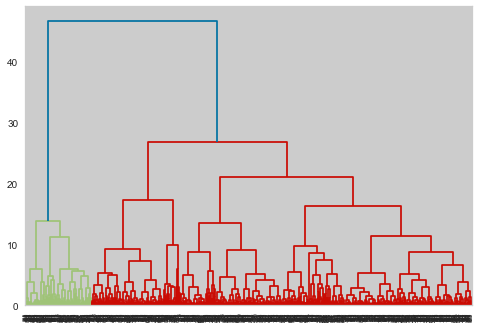

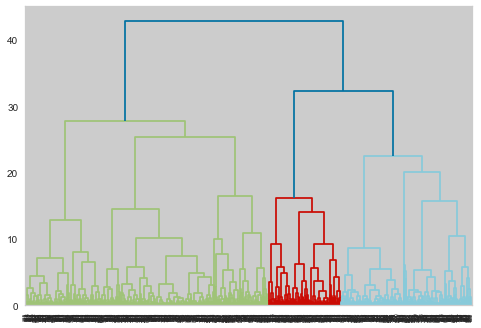

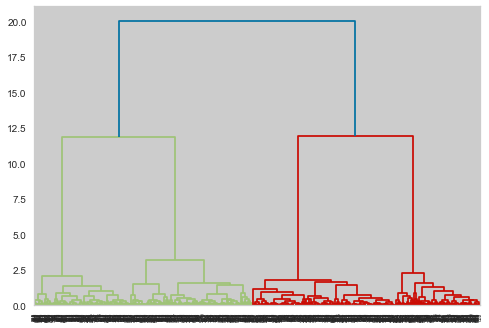

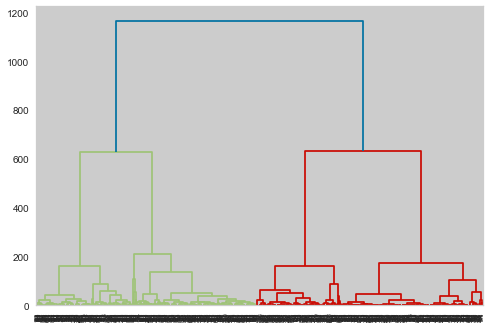

In [47]:
for data in [groupby_domains_RobustScaler,groupby_domains_StandardScaler,minmax, groupby_domains_clustering]:
    Z = linkage(data, 'ward') #'single', 'ward', ...
    dendrogram(Z)
    plt.show()

- ### ROBUSTSCALER transformation

In [48]:
from scipy.cluster.hierarchy import fcluster
cut_distance = 20
clusters_hc = fcluster(linkage(groupby_domains_RobustScaler, 'ward'), t = cut_distance, criterion='distance')
np.unique(clusters_hc, return_counts = True)

(array([1, 2, 3, 4], dtype=int32), array([134, 179, 205, 383], dtype=int64))

In [50]:
cluster = AgglomerativeClustering(n_clusters=4)  
cluster.fit(groupby_domains_RobustScaler)
results_evaluation(cluster, groupby_domains_RobustScaler)

CLUSTERING DIVISION:
 2    383
3    205
0    179
1    134
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Geographical zone importance
Cluster,,,,,,,,,,,
0,139380.06,26025.13,24.40,79.50,94.83,1.65,113.66,0.44,74.68,29.59,35.13
1,82195.19,5869.94,7.01,39.73,47.26,0.80,33.07,0.28,35.97,24.26,23.38
2,118109.33,8526.51,7.71,80.35,89.31,1.57,79.36,0.81,70.05,41.04,44.99
3,137633.75,4808.11,4.55,75.84,87.47,1.66,17.05,0.34,65.65,21.32,16.55


The Silhouette Score is:  0.20724091362387015
The Calinski Harabasz Score is:  300.95624595898136
The Davies Douldin Score is:  1.442615439944944


- ### STANDARDSCALER transformation

In [51]:
from scipy.cluster.hierarchy import fcluster
cut_distance = 20
clusters_hc = fcluster(linkage(groupby_domains_StandardScaler, 'ward'), t = cut_distance, criterion='distance')
np.unique(clusters_hc, return_counts = True)

(array([1, 2, 3, 4, 5, 6, 7], dtype=int32),
 array([154, 227, 110, 146, 126,   8, 130], dtype=int64))

In [52]:
cluster = AgglomerativeClustering(n_clusters=7)  
cluster.fit(groupby_domains_StandardScaler)
results_evaluation(cluster, groupby_domains_StandardScaler)

CLUSTERING DIVISION:
 4    227
3    154
2    146
1    130
5    126
0    110
6      8
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Geographical zone importance
Cluster,,,,,,,,,,,
0,134006.89,11131.23,7.21,82.10,91.22,1.58,138.88,1.22,67.78,40.22,30.26
1,153334.73,13578.37,13.70,78.13,91.11,1.62,58.33,0.43,69.32,47.87,10.76
2,82084.16,5365.45,5.82,41.79,49.86,0.86,27.16,0.26,37.94,22.22,23.67
3,123588.00,14354.75,12.97,78.33,90.56,1.61,72.49,0.58,71.36,4.50,53.27
4,118896.69,11400.23,11.29,80.55,89.78,1.62,68.07,0.60,73.64,58.61,53.27
5,127007.98,5234.41,5.17,75.76,88.72,1.62,17.76,0.29,64.49,3.53,11.17
6,91289.01,58173.35,69.49,86.75,97.23,1.75,373.15,0.65,79.95,37.96,20.01


The Silhouette Score is:  0.27512563931979195
The Calinski Harabasz Score is:  204.0303371479628
The Davies Douldin Score is:  1.1944254553706788


- ### MINMAX transformation

In [53]:
from scipy.cluster.hierarchy import fcluster
cut_distance = 5
clusters_hc = fcluster(linkage(minmax, 'ward'), t = cut_distance, criterion='distance')
np.unique(clusters_hc, return_counts = True)

(array([1, 2, 3, 4], dtype=int32), array([194, 249, 286, 172], dtype=int64))

In [54]:
cluster = AgglomerativeClustering(n_clusters=4)  
cluster.fit(minmax)
results_evaluation(cluster, minmax)

CLUSTERING DIVISION:
 2    286
0    249
3    194
1    172
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Geographical zone importance
Cluster,,,,,,,,,,,
0,108567.48,6587.40,8.07,67.24,79.03,1.41,28.42,0.39,57.42,3.81,10.95
1,151141.77,11822.60,10.21,72.89,83.91,1.48,71.30,0.53,63.72,58.61,10.18
2,120915.15,11953.75,10.59,78.76,87.37,1.57,86.98,0.69,71.12,58.61,53.27
3,112384.32,13421.98,12.35,72.54,84.25,1.49,74.47,0.56,66.38,4.36,53.27


The Silhouette Score is:  0.7171556372743594
The Calinski Harabasz Score is:  2892.3414654427947
The Davies Douldin Score is:  0.4272316608096348


- ### RAW transformation

In [55]:
from scipy.cluster.hierarchy import fcluster
cut_distance = 400
clusters_hc = fcluster(linkage(groupby_domains_clustering, 'ward'), t = cut_distance, criterion='distance')
np.unique(clusters_hc, return_counts = True)

(array([1, 2, 3, 4], dtype=int32), array([194, 250, 171, 286], dtype=int64))

In [57]:
cluster = AgglomerativeClustering(n_clusters=4)  
cluster.fit(groupby_domains_clustering)
results_evaluation(cluster, groupby_domains_clustering)

CLUSTERING DIVISION:
 1    286
0    250
3    194
2    171
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Geographical zone importance
Cluster,,,,,,,,,,,
0,108269.92,6738.16,8.49,67.33,79.09,1.41,29.19,0.40,57.55,4.03,10.94
1,120915.15,11953.75,10.59,78.76,87.37,1.57,86.98,0.69,71.12,58.61,53.27
2,151825.78,11632.80,9.62,72.78,83.84,1.48,70.42,0.52,63.57,58.61,10.19
3,112384.32,13421.98,12.35,72.54,84.25,1.49,74.47,0.56,66.38,4.36,53.27


The Silhouette Score is:  0.7549348692332781
The Calinski Harabasz Score is:  2802.939351413443
The Davies Douldin Score is:  0.3890322673762485


## DBSCAN

- First, I´m going to find the optimal value of eps, the value for which two points are considered neighbors if the distance between the two points is below the threshold epsilon. We can calculate the distance from each point to its closest neighbour using the NearestNeighbors. The point itself is included in n_neighbors. The kneighbors method returns two arrays, one which contains the distance to the closest n_neighbors points and the other which contains the index for each of those points.

- ### With MINMAX Scaler Data

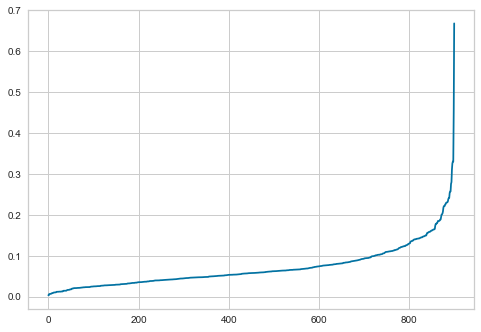

In [58]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(p=1)
nbrs = neigh.fit(minmax)
distances, indices = nbrs.kneighbors(minmax)

#Next, I sort and plot results.
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [61]:
from sklearn.cluster import DBSCAN
dbs = DBSCAN(eps=0.25, min_samples=5)
dbs = dbs.fit(minmax)

id_clusters = np.unique(dbs.labels_)
print('Found {} clusters'.format(len(id_clusters)))
np.unique(dbs.labels_, return_counts=True)

Found 5 clusters


(array([-1,  0,  1,  2,  3], dtype=int64),
 array([  3, 248, 171, 194, 285], dtype=int64))

In [62]:
results_evaluation(dbs,minmax)

CLUSTERING DIVISION:
  3    285
 0    248
 2    194
 1    171
-1      3
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Geographical zone importance
Cluster,,,,,,,,,,,
-1,33833.46,21122.29,66.14,84.00,97.60,1.98,87.23,1.60,78.59,39.73,23.30
0,108888.99,6537.80,7.76,67.23,78.95,1.40,28.39,0.40,57.38,3.82,10.96
1,151825.78,11632.80,9.62,72.78,83.84,1.48,70.42,0.52,63.57,58.61,10.19
2,112384.32,13421.98,12.35,72.54,84.25,1.49,74.47,0.56,66.38,4.36,53.27
3,121204.36,11994.98,10.62,78.72,87.33,1.57,87.27,0.68,71.10,58.61,53.27


The Silhouette Score is:  0.7168776840902238
The Calinski Harabasz Score is:  2162.9451363303106
The Davies Douldin Score is:  1.2066744439355541


- ### With Standard Scaler Data

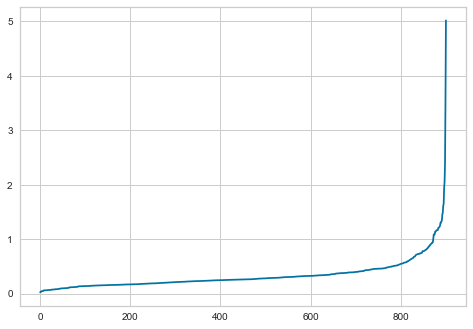

In [63]:
neigh = NearestNeighbors()
nbrs = neigh.fit(groupby_domains_StandardScaler)
distances, indices = nbrs.kneighbors(groupby_domains_StandardScaler)

#Next, I sort and plot results.
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [64]:
from sklearn.cluster import DBSCAN
dbs = DBSCAN(eps=1, min_samples=5)
dbs = dbs.fit(groupby_domains_StandardScaler)

id_clusters = np.unique(dbs.labels_)
print('Found {} clusters'.format(len(id_clusters)))
np.unique(dbs.labels_, return_counts=True)

Found 5 clusters


(array([-1,  0,  1,  2,  3], dtype=int64),
 array([ 39, 236, 162, 187, 277], dtype=int64))

In [65]:
results_evaluation(dbs, groupby_domains_StandardScaler )

CLUSTERING DIVISION:
  3    277
 0    236
 2    187
 1    162
-1     39
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Geographical zone importance
Cluster,,,,,,,,,,,
-1,91701.32,22217.99,28.78,70.60,78.72,1.53,132.32,0.86,62.19,30.38,27.57
0,111729.60,6069.77,6.70,67.22,79.00,1.41,26.14,0.37,57.22,3.83,10.97
1,153877.58,10203.47,8.29,72.44,83.61,1.47,62.88,0.50,63.18,58.61,10.28
2,108578.62,12780.62,12.04,72.30,84.23,1.48,68.50,0.55,66.50,4.37,53.27
3,123599.53,12110.04,10.45,79.44,88.20,1.58,87.86,0.69,71.76,58.61,53.27


The Silhouette Score is:  0.31316169679436334
The Calinski Harabasz Score is:  179.50792505201187
The Davies Douldin Score is:  2.0716473310781907


- ### With Robust Scaler Data

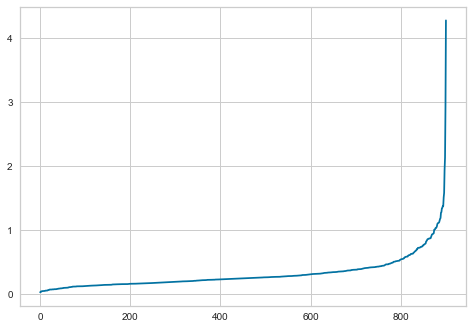

In [66]:
neigh = NearestNeighbors()
nbrs = neigh.fit(groupby_domains_RobustScaler)
distances, indices = nbrs.kneighbors(groupby_domains_RobustScaler)

#Next, I sort and plot results.
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [67]:
from sklearn.cluster import DBSCAN
dbs = DBSCAN(eps=0.8, min_samples=5)
dbs = dbs.fit(groupby_domains_RobustScaler)

id_clusters = np.unique(dbs.labels_)
print('Found {} clusters'.format(len(id_clusters)))
np.unique(dbs.labels_, return_counts=True)

Found 6 clusters


(array([-1,  0,  1,  2,  3,  4], dtype=int64),
 array([ 69, 219, 152, 185, 271,   5], dtype=int64))

In [68]:
results_evaluation(dbs, groupby_domains_RobustScaler )

CLUSTERING DIVISION:
  3    271
 0    219
 2    185
 1    152
-1     69
 4      5
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Geographical zone importance
Cluster,,,,,,,,,,,
-1,115536.74,22989.52,24.22,69.61,77.41,1.46,169.97,0.72,62.04,31.41,25.32
0,115427.86,6173.27,6.36,68.32,80.56,1.44,25.83,0.37,58.35,3.91,10.94
1,150667.97,9517.89,7.71,73.09,84.46,1.50,52.16,0.50,63.58,58.61,10.28
2,107229.60,11868.12,11.63,72.25,84.06,1.47,66.86,0.55,66.33,4.38,53.27
3,122574.64,11489.59,10.34,79.49,88.49,1.57,77.42,0.69,71.72,58.61,53.27
4,41301.80,432.05,0.59,18.44,17.99,0.05,0.60,0.03,9.26,2.25,9.90


The Silhouette Score is:  0.09905026335103806
The Calinski Harabasz Score is:  57.03497704825933
The Davies Douldin Score is:  2.4656361986838307


## OPTICS

In [72]:
optics = OPTICS(min_samples=20).fit(minmax)

In [73]:
results_evaluation(optics,minmax)

CLUSTERING DIVISION:
 -1    311
 3    250
 1    194
 2    123
 0     23
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Geographical zone importance
Cluster,,,,,,,,,,,
-1,121019.69,9241.72,9.65,67.87,78.78,1.41,51.31,0.46,58.67,18.76,15.25
0,45357.94,1943.58,2.43,30.36,36.30,0.65,8.52,0.11,27.02,4.22,10.98
1,112384.32,13421.98,12.35,72.54,84.25,1.49,74.47,0.56,66.38,4.36,53.27
2,150533.60,11982.98,9.73,78.78,90.99,1.61,71.84,0.53,68.49,58.61,11.36
3,121661.73,10798.95,10.16,81.24,90.29,1.61,76.90,0.70,73.22,58.61,53.27


The Silhouette Score is:  0.3975479217570823
The Calinski Harabasz Score is:  563.662850883453
The Davies Douldin Score is:  1.0057974915913048


## PCA + KMEANS

By reducing the number of features, we’re improving the performance of our algorithm. On top of that, by decreasing the number of features the noise is also reduced.
In the case of PCA and K-means in particular, there appears to be an even closer relationship between the two.

- **With the Robust Scaler data**

Text(0, 0.5, 'Cumulative explained variance')

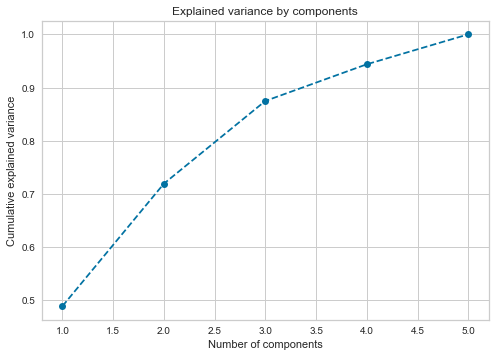

In [77]:
pca = PCA()
pca.fit(groupby_domains_RobustScaler)
plt.plot(range(1,6), pca.explained_variance_ratio_.cumsum(), marker= 'o' , linestyle = '--')
plt.title('Explained variance by components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

 A rule of thumb is to preserve around 80 % of the variance. So, in this instance, I decide to keep 4 components. I´ll perform PCA with the chosen number of components.

In [78]:
pca_robustscaler = PCA(n_components=3)
pca_robustscaler = pca_robustscaler.fit_transform(groupby_domains_RobustScaler)

C:\Users\Usuario\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Usuario\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Usuario\anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


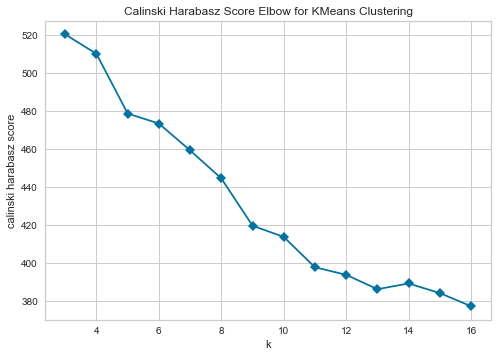

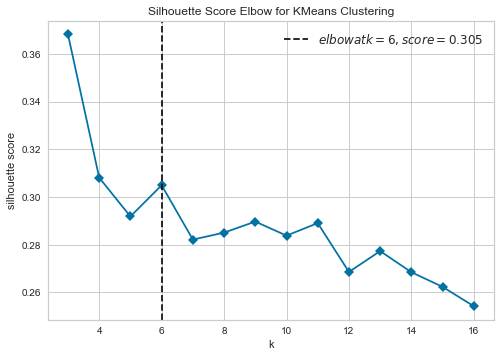

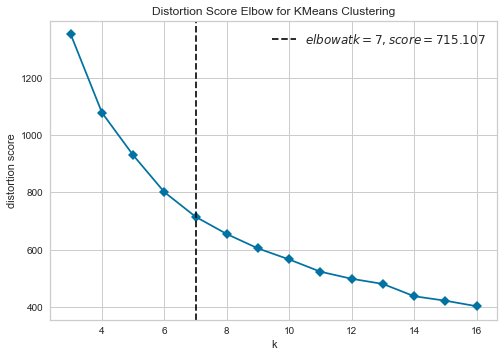

In [79]:
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
visualization_clusters(pca_robustscaler, model)

- Initializing the KElbowVisualizer several times with the 3 kind of metrics (distortion, Silhouette and calinski_harabasz) the optimal number of clusters is between 5-7

In [80]:
kmeans_pca_robustscaler = KMeans(n_clusters=6, init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
kmeans_pca_robustscaler.fit(pca_robustscaler)
results_evaluation(kmeans_pca_robustscaler, pca_robustscaler)

CLUSTERING DIVISION:
 2    224
0    202
5    193
4    165
1    106
3     11
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Geographical zone importance
Cluster,,,,,,,,,,,
0,98478.09,5413.90,6.29,70.63,80.82,1.39,31.38,0.46,62.57,27.80,31.82
1,80500.82,4856.33,4.80,35.10,41.84,0.71,28.17,0.24,31.61,22.87,24.16
2,125900.50,8843.87,7.19,83.72,91.96,1.63,94.05,1.02,71.11,43.32,42.71
3,110748.90,60980.12,64.01,84.40,97.84,1.77,315.60,0.56,80.56,33.64,29.08
4,125537.60,24378.06,24.22,79.01,93.45,1.60,123.44,0.51,73.98,32.47,38.33
5,159868.71,7325.49,5.70,78.60,91.13,1.75,22.96,0.31,69.77,26.76,25.11


The Silhouette Score is:  0.3045904416030232
The Calinski Harabasz Score is:  462.2989714414833
The Davies Douldin Score is:  0.9195397038048462


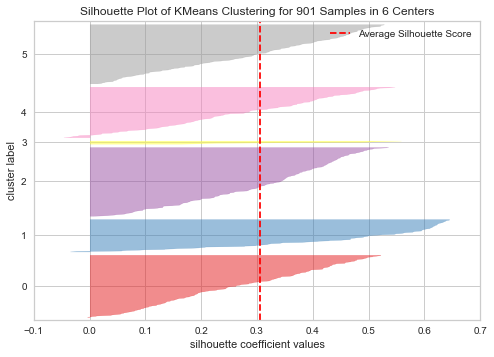

In [81]:
sv = SilhouetteVisualizer(kmeans_pca_robustscaler)
sv.fit(pca_robustscaler)
sv.show()

- **With the Standard Scaler Data**

Text(0, 0.5, 'Cumulative explained variance')

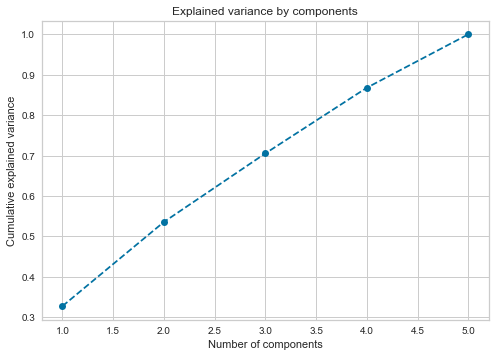

In [82]:
pca = PCA()
pca.fit(groupby_domains_StandardScaler)
plt.plot(range(1,6), pca.explained_variance_ratio_.cumsum(), marker= 'o' , linestyle = '--')
plt.title('Explained variance by components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

 A rule of thumb is to preserve around 80 % of the variance. So, in this instance, I decide to keep 4 components. I´ll perform PCA with the chosen number of components.

In [83]:
pca_standardscaler = PCA(n_components=4)
pca_standardscaler = pca_standardscaler.fit_transform(groupby_domains_StandardScaler)

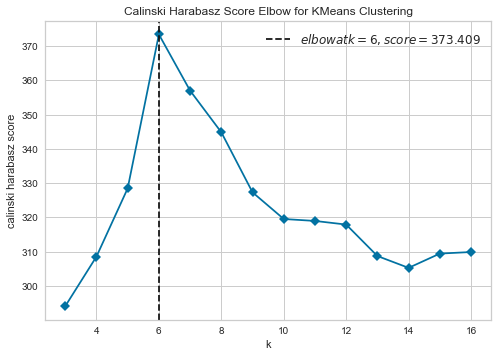

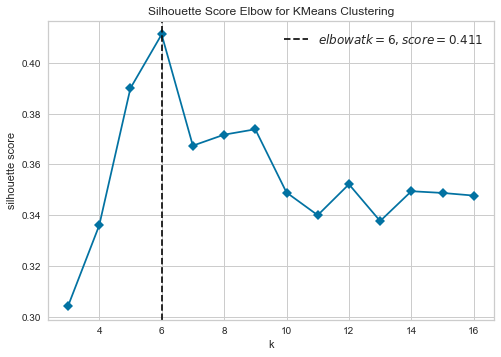

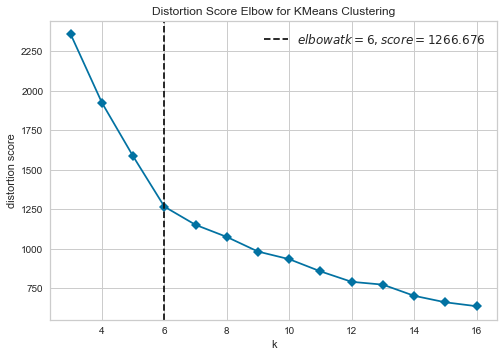

In [84]:
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
visualization_clusters(pca_standardscaler, model)

- Initializing the KElbowVisualizer several times with the 3 kind of metrics (distortion, Silhouette and calinski_harabasz) the optimal number of clusters is between 8-10

In [86]:
kmeans_pca_standardscaler = KMeans(n_clusters=6, init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
kmeans_pca_standardscaler.fit(pca_standardscaler)
results_evaluation(kmeans_pca_standardscaler, pca_standardscaler)

CLUSTERING DIVISION:
 1    255
0    190
2    163
3    143
5    100
4     50
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Geographical zone importance
Cluster,,,,,,,,,,,
0,118966.28,6524.19,6.96,75.17,88.24,1.59,26.88,0.44,63.79,3.82,11.06
1,122775.40,10457.89,9.13,81.23,89.34,1.61,87.49,0.75,72.72,58.61,52.78
2,113783.44,10020.72,11.20,76.80,88.39,1.56,68.03,0.62,69.53,4.35,52.75
3,158903.60,10574.48,8.67,77.26,89.01,1.57,64.11,0.55,67.33,58.61,10.14
4,126645.30,43576.50,41.17,78.08,93.52,1.65,165.87,0.38,76.03,34.84,38.36
5,79004.78,4656.75,4.14,34.11,40.81,0.71,26.98,0.21,30.51,21.32,25.17


The Silhouette Score is:  0.4109110456737749
The Calinski Harabasz Score is:  373.4824928679564
The Davies Douldin Score is:  0.8956192474176191


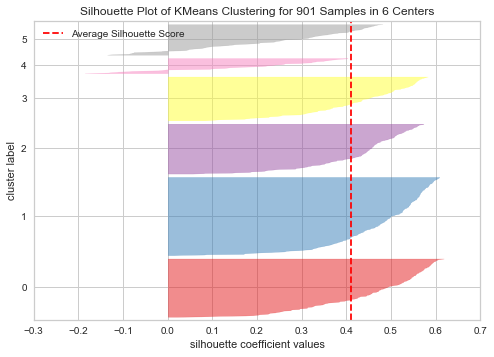

In [87]:
sv = SilhouetteVisualizer(kmeans_pca_standardscaler)
sv.fit(pca_standardscaler)
sv.show()

- **With the Minmax Scaler Data**

Text(0, 0.5, 'Cumulative explained variance')

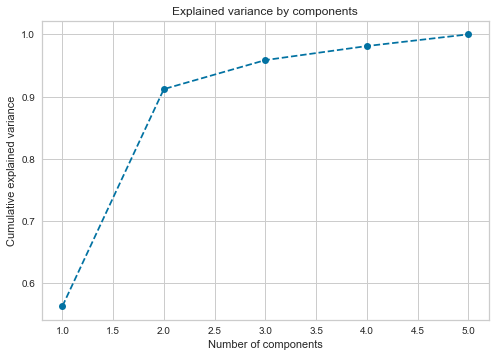

In [88]:
pca = PCA()
pca.fit(minmax)
plt.plot(range(1,6), pca.explained_variance_ratio_.cumsum(), marker= 'o' , linestyle = '--')
plt.title('Explained variance by components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

 A rule of thumb is to preserve around 80 % of the variance. So, in this instance, I decide to keep 4 components. I´ll perform PCA with the chosen number of components.

In [89]:
pca_minmax = PCA(n_components=2)
pca_minmax = pca_minmax.fit_transform(minmax)

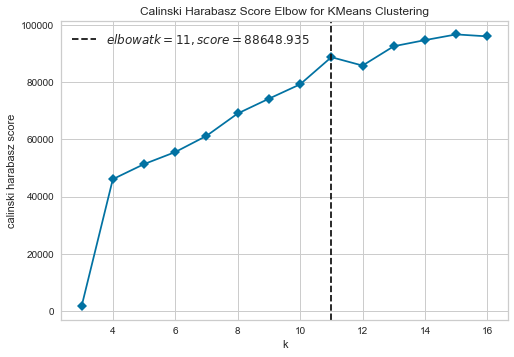

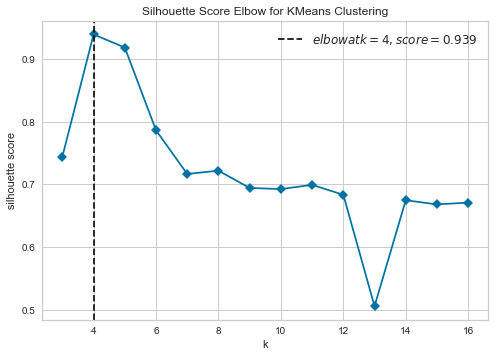

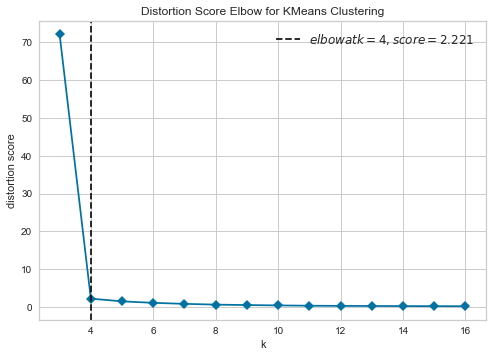

In [90]:
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
visualization_clusters(pca_minmax, model)

- Initializing the KElbowVisualizer several times with the 3 kind of metrics (distortion, Silhouette and calinski_harabasz) the optimal number of clusters is between 8-10

In [91]:
kmeans_pca_minmax = KMeans(n_clusters=4, init='k-means++', max_iter=1000, n_init=5, algorithm='elkan')
kmeans_pca_minmax.fit(pca_minmax)
results_evaluation(kmeans_pca_minmax, pca_minmax)

CLUSTERING DIVISION:
 0    286
1    249
3    194
2    172
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Geographical zone importance
Cluster,,,,,,,,,,,
0,120915.15,11953.75,10.59,78.76,87.37,1.57,86.98,0.69,71.12,58.61,53.27
1,108567.48,6587.40,8.07,67.24,79.03,1.41,28.42,0.39,57.42,3.81,10.95
2,151141.77,11822.60,10.21,72.89,83.91,1.48,71.30,0.53,63.72,58.61,10.18
3,112384.32,13421.98,12.35,72.54,84.25,1.49,74.47,0.56,66.38,4.36,53.27


The Silhouette Score is:  0.9390588867049904
The Calinski Harabasz Score is:  46054.04792525523
The Davies Douldin Score is:  0.10759213828891492


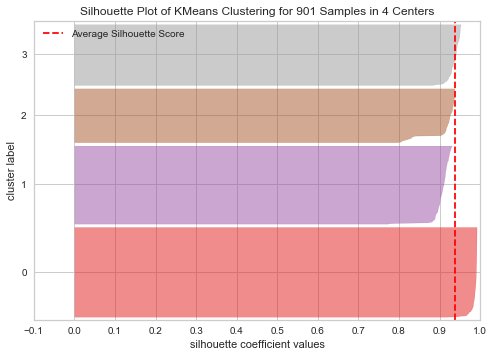

In [92]:
sv = SilhouetteVisualizer(kmeans_pca_minmax)
sv.fit(pca_minmax)
sv.show()

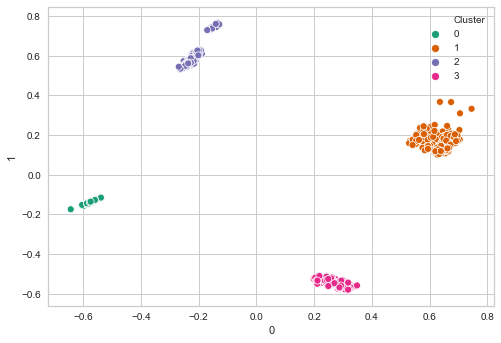

In [93]:
pca_minmax_df = pd.DataFrame(pca_minmax.copy())
pca_minmax_df['Cluster'] = kmeans_pca_minmax.labels_
sns.scatterplot(pca_minmax_df[0],pca_minmax_df[1],hue=pca_minmax_df['Cluster'], palette='Dark2')

- **With the orginal/raw Data**

Text(0, 0.5, 'Cumulative explained variance')

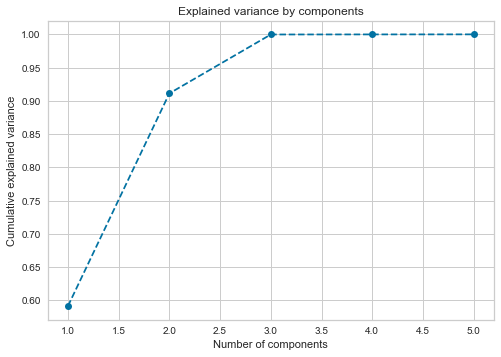

In [94]:
pca = PCA()
pca.fit(groupby_domains_clustering)
plt.plot(range(1,6), pca.explained_variance_ratio_.cumsum(), marker= 'o' , linestyle = '--')
plt.title('Explained variance by components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

 A rule of thumb is to preserve around 80 % of the variance. So, in this instance, I decide to keep 4 components. I´ll perform PCA with the chosen number of components.

In [95]:
pca_rawdata = PCA(n_components=2)
pca_rawdata = pca_rawdata.fit_transform(groupby_domains_clustering)

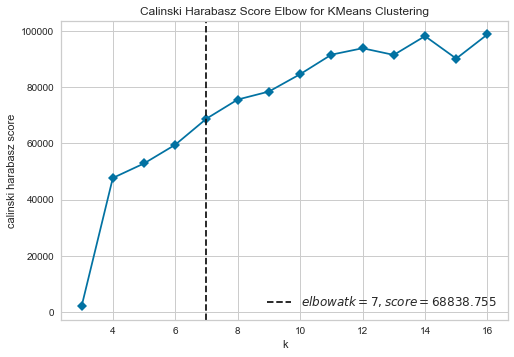

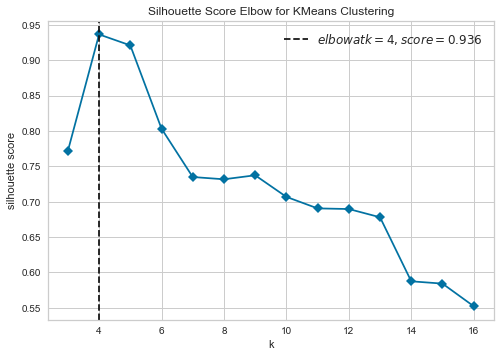

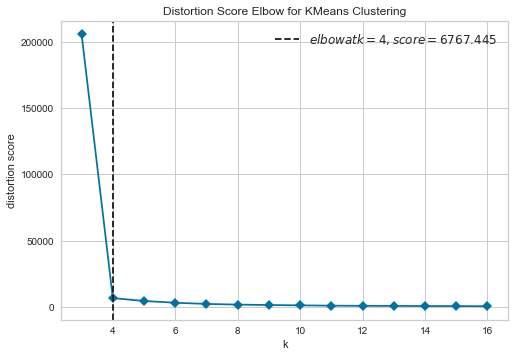

In [96]:
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
visualization_clusters(pca_rawdata, model)

- Initializing the KElbowVisualizer several times with the 3 kind of metrics (distortion, Silhouette and calinski_harabasz) the optimal number of clusters is between 8-10

In [97]:
kmeans_pca_rawdata = KMeans(n_clusters=4, init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
kmeans_pca_rawdata.fit(pca_rawdata)
results_evaluation(kmeans_pca_rawdata, pca_rawdata)

CLUSTERING DIVISION:
 2    286
1    249
3    194
0    172
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Geographical zone importance
Cluster,,,,,,,,,,,
0,151141.77,11822.60,10.21,72.89,83.91,1.48,71.30,0.53,63.72,58.61,10.18
1,108567.48,6587.40,8.07,67.24,79.03,1.41,28.42,0.39,57.42,3.81,10.95
2,120915.15,11953.75,10.59,78.76,87.37,1.57,86.98,0.69,71.12,58.61,53.27
3,112384.32,13421.98,12.35,72.54,84.25,1.49,74.47,0.56,66.38,4.36,53.27


The Silhouette Score is:  0.9363569829715626
The Calinski Harabasz Score is:  47685.61437258009
The Davies Douldin Score is:  0.1088213669937303


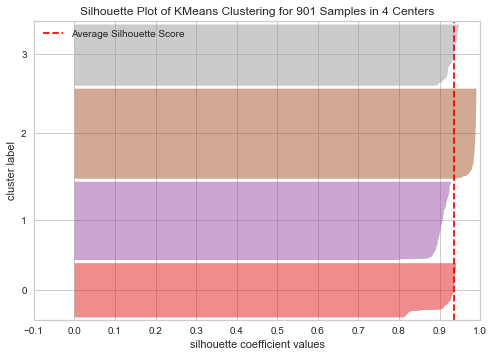

In [98]:
sv = SilhouetteVisualizer(kmeans_pca_rawdata)
sv.fit(pca_rawdata)
sv.show()

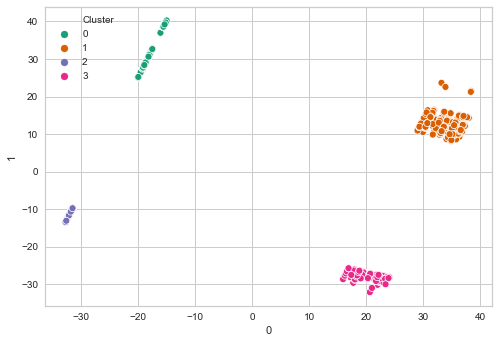

In [99]:
pca_rawdata_df = pd.DataFrame(pca_rawdata.copy())
pca_rawdata_df['Cluster'] = kmeans_pca_rawdata.labels_
sns.scatterplot(pca_rawdata_df[0],pca_rawdata_df[1],hue=pca_rawdata_df['Cluster'], palette='Dark2')

- ### Conclussions:

K-Means + PCA transformation with the Minmax Scaler data gives a significant better result than the K-Means algorithm without PCA. The Silhouette Score with 8 cluster is about 90%.

## K-MEDOIDS

- ### With the Robust Scaler Data

In [100]:
%run KMEDOIDS.py

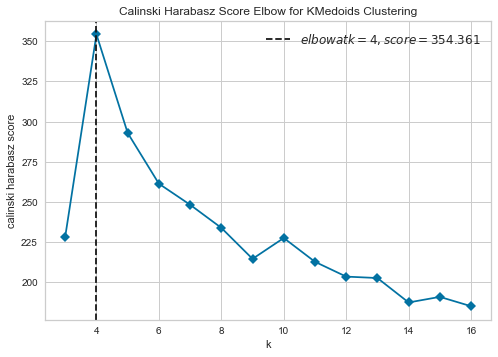

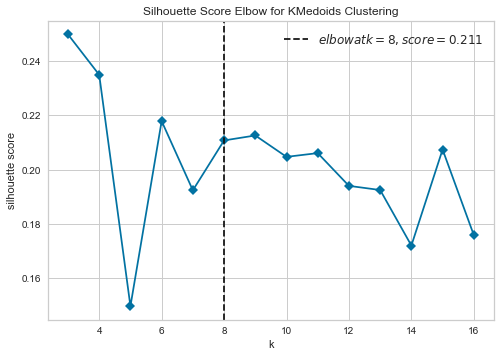

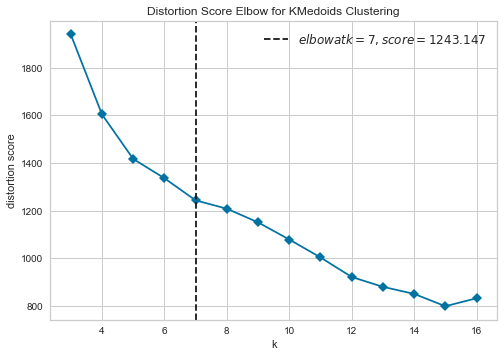

In [101]:
# Instantiate the clustering model and visualizer
model = KMedoids(init= 'k-medoids++')

visualization_clusters(groupby_domains_RobustScaler,model)

In [102]:
kmedoids_robust = KMedoids(n_clusters = 4, init= 'k-medoids++')
kmedoids_robust.fit(groupby_domains_RobustScaler)
results_evaluation(kmedoids_robust, groupby_domains_RobustScaler )

CLUSTERING DIVISION:
 0    344
3    287
2    146
1    124
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Geographical zone importance
Cluster,,,,,,,,,,,
0,117055.96,8160.67,7.58,81.38,89.52,1.59,73.93,0.84,70.54,45.25,46.17
1,84182.32,5020.82,5.17,37.88,45.02,0.77,29.85,0.27,34.07,23.22,23.05
2,120411.83,29088.01,28.64,78.84,93.45,1.62,151.22,0.49,74.69,35.59,38.85
3,143303.11,7037.22,6.14,75.53,88.58,1.62,25.97,0.35,66.48,17.41,19.62


The Silhouette Score is:  0.23719852984400933
The Calinski Harabasz Score is:  355.5216680382775
The Davies Douldin Score is:  1.3518077112509808


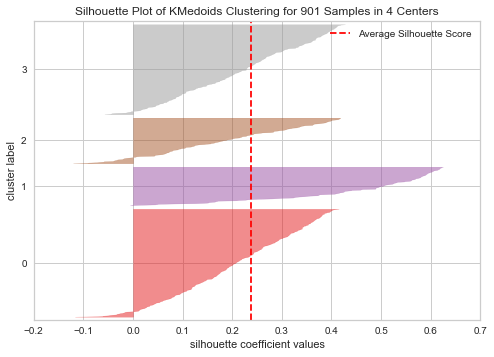

In [103]:
sv = SilhouetteVisualizer(kmedoids_robust)
sv.fit(groupby_domains_RobustScaler)
sv.show()

- ### With the Standard Scaler Data

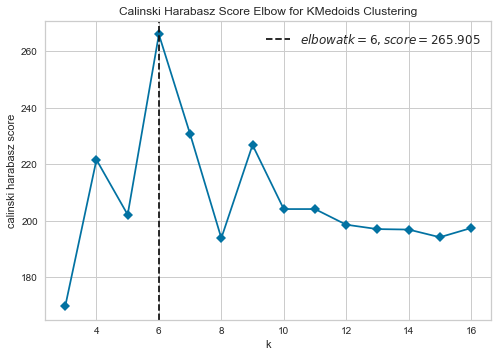

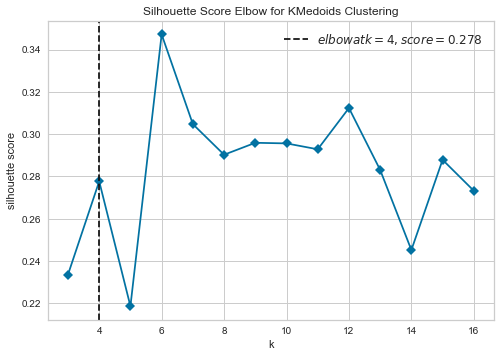

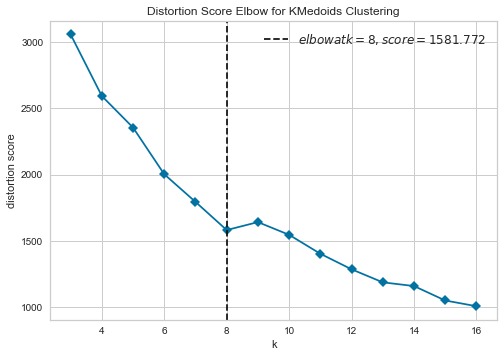

In [104]:
# Instantiate the clustering model and visualizer
model = KMedoids(init= 'k-medoids++')
visualization_clusters(groupby_domains_StandardScaler,model)

In [105]:
kmedoids_standard = KMedoids(n_clusters = 6, init= 'k-medoids++')
kmedoids_standard.fit(groupby_domains_StandardScaler)
results_evaluation(kmedoids_standard, groupby_domains_StandardScaler )

CLUSTERING DIVISION:
 1    279
5    172
3    169
4    146
0     84
2     51
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Geographical zone importance
Cluster,,,,,,,,,,,
0,69021.65,3127.12,3.94,31.81,38.27,0.66,19.58,0.20,28.06,16.18,20.42
1,122669.83,11737.13,10.05,79.71,88.26,1.59,87.25,0.71,71.80,58.61,52.97
2,116398.99,38384.61,38.85,77.09,91.32,1.61,153.18,0.42,72.56,19.69,23.47
3,111446.88,9857.35,11.02,75.89,87.49,1.54,65.39,0.61,68.81,4.37,53.03
4,158243.73,10393.49,8.44,76.64,88.30,1.55,64.19,0.54,66.82,58.61,10.17
5,125097.80,5919.13,5.72,75.70,88.76,1.60,25.82,0.44,63.98,3.64,11.09


The Silhouette Score is:  0.34425406802302544
The Calinski Harabasz Score is:  257.2622337097338
The Davies Douldin Score is:  1.1055163849757117


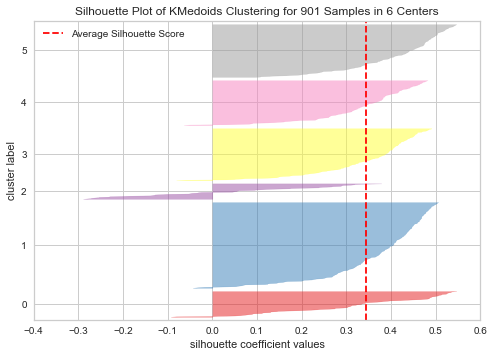

In [106]:
sv = SilhouetteVisualizer(kmedoids_standard)
sv.fit(groupby_domains_StandardScaler)
sv.show()

- ### With the MinMax Scaler Data

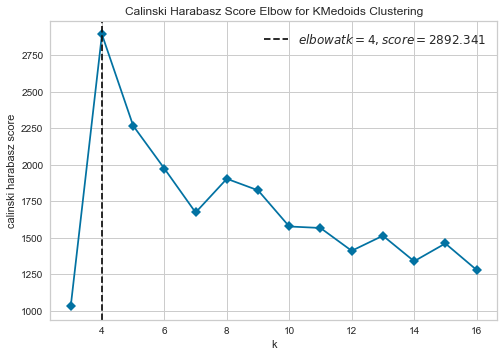

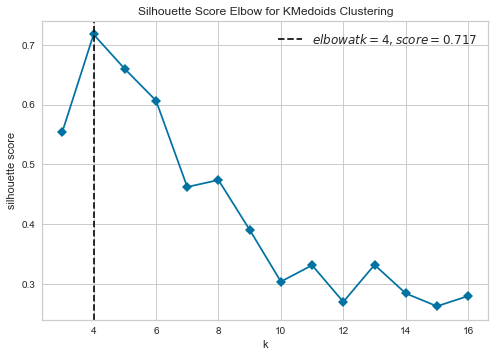

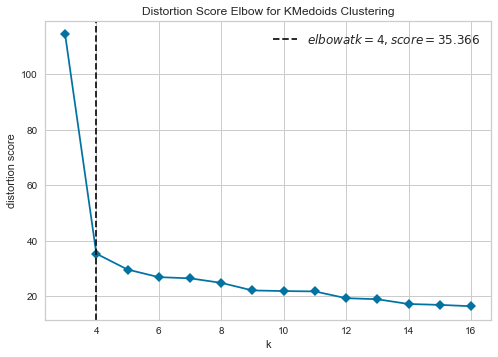

In [107]:
# Instantiate the clustering model and visualizer
model = KMedoids(init= 'k-medoids++')
visualization_clusters(minmax,model)

In [108]:
kmedoids_minmax = KMedoids(n_clusters = 4, init= 'k-medoids++')
kmedoids_minmax.fit(minmax)
results_evaluation(kmedoids_minmax, minmax )

CLUSTERING DIVISION:
 2    286
3    249
1    194
0    172
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Geographical zone importance
Cluster,,,,,,,,,,,
0,151141.77,11822.60,10.21,72.89,83.91,1.48,71.30,0.53,63.72,58.61,10.18
1,112384.32,13421.98,12.35,72.54,84.25,1.49,74.47,0.56,66.38,4.36,53.27
2,120915.15,11953.75,10.59,78.76,87.37,1.57,86.98,0.69,71.12,58.61,53.27
3,108567.48,6587.40,8.07,67.24,79.03,1.41,28.42,0.39,57.42,3.81,10.95


The Silhouette Score is:  0.7171556372743594
The Calinski Harabasz Score is:  2892.341465442794
The Davies Douldin Score is:  0.4272316608096348


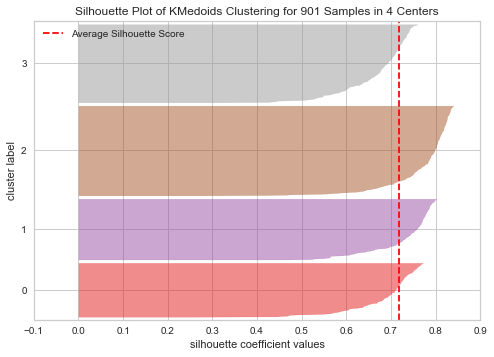

In [109]:
sv = SilhouetteVisualizer(kmedoids_minmax)
sv.fit(minmax)
sv.show()

- ### With the Raw Data

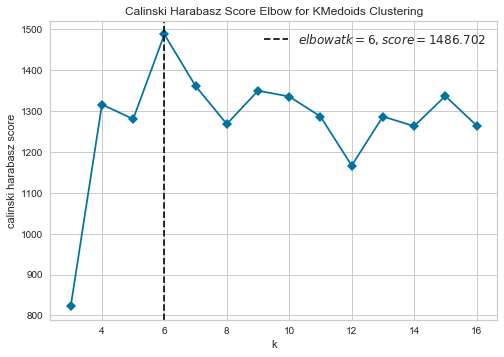

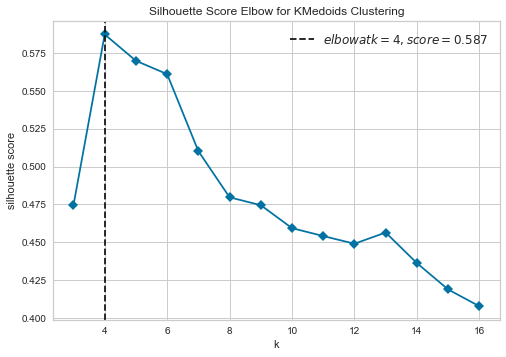

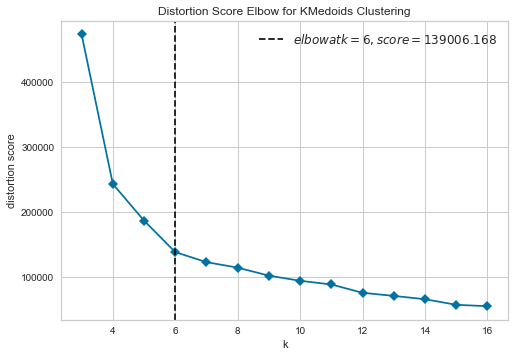

In [215]:
# Instantiate the clustering model and visualizer
model = KMedoids(init= 'k-medoids++')
visualization_clusters(groupby_domains_clustering,model)

In [219]:
kmedoids_raw = KMedoids(n_clusters = 5, init= 'k-medoids++')
kmedoids_raw.fit(groupby_domains_clustering)
results_evaluation(kmedoids_raw, groupby_domains_clustering )

CLUSTERING DIVISION:
 0    225
3    162
1    134
2    128
4     85
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Domain Recurrence,Category importance
Cluster,,,,,,,,,,,
0,146895.67,15776.97,11.70,77.54,89.59,1.57,109.15,0.65,70.31,89.48,58.61
1,126623.41,6821.64,6.50,68.67,78.29,1.43,38.21,0.41,58.58,10.29,4.10
2,133371.83,17432.03,13.01,73.09,88.98,1.55,84.87,0.53,67.41,93.65,4.19
3,159058.31,10608.42,9.20,75.77,82.70,1.50,71.63,0.62,66.49,30.62,58.61
4,146357.05,9522.71,8.99,65.36,76.06,1.34,46.92,0.45,58.04,47.56,4.33


The Silhouette Score is:  0.5676331949529552
The Calinski Harabasz Score is:  1279.9624723430638
The Davies Douldin Score is:  0.5983591054733969


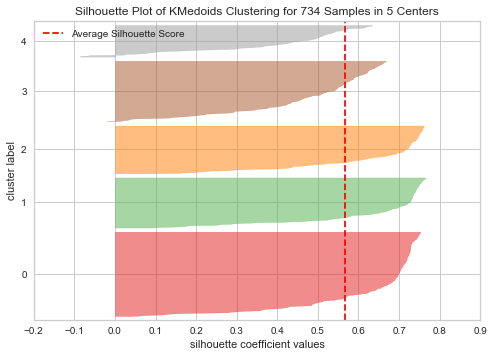

In [220]:
sv = SilhouetteVisualizer(kmedoids_raw)
sv.fit(groupby_domains_clustering)
sv.show()

- **With the PCA scores**

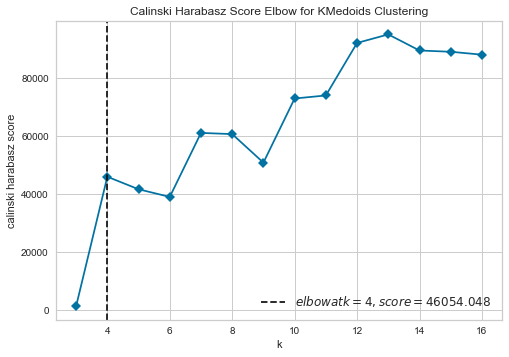

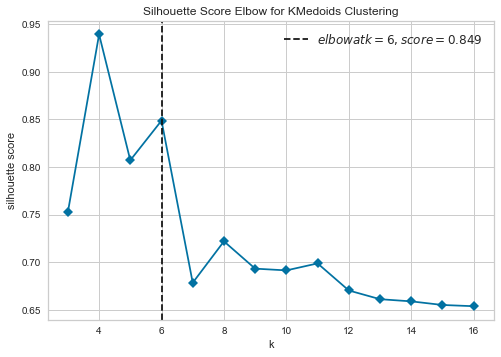

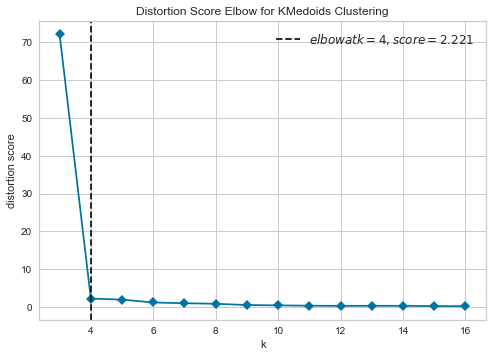

In [110]:
# Instantiate the clustering model and visualizer
model = KMedoids(init= 'k-medoids++')
visualization_clusters(pca_minmax,model)

In [111]:
kmedoids_pca_minmax = KMedoids(n_clusters = 4, init= 'k-medoids++')
kmedoids_pca_minmax.fit(pca_minmax)
results_evaluation(kmedoids_pca_minmax, pca_minmax )

CLUSTERING DIVISION:
 1    286
2    249
0    194
3    172
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Geographical zone importance
Cluster,,,,,,,,,,,
0,112384.32,13421.98,12.35,72.54,84.25,1.49,74.47,0.56,66.38,4.36,53.27
1,120915.15,11953.75,10.59,78.76,87.37,1.57,86.98,0.69,71.12,58.61,53.27
2,108567.48,6587.40,8.07,67.24,79.03,1.41,28.42,0.39,57.42,3.81,10.95
3,151141.77,11822.60,10.21,72.89,83.91,1.48,71.30,0.53,63.72,58.61,10.18


The Silhouette Score is:  0.9390588867049904
The Calinski Harabasz Score is:  46054.04792525523
The Davies Douldin Score is:  0.10759213828891492


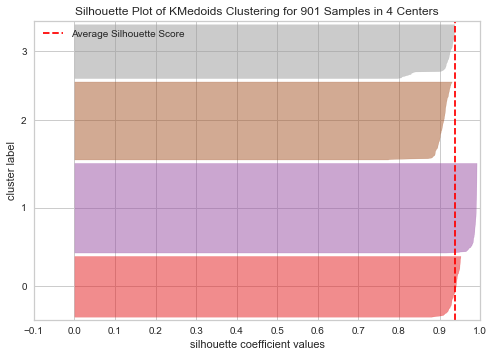

In [112]:
sv = SilhouetteVisualizer(kmedoids_pca_minmax)
sv.fit(pca_minmax)
sv.show()

# *TESTS RESULTS*

In [95]:
tests_results = pd.read_csv('RESULTS CLUSTERING TESTS.csv')

In [96]:
tests_results.sort_values(by= 'SILHOUETTE SCORE', ascending =False).head(5)

,DATA TRANSFORMATION,ALGORITHM,NºCLUSTERS,SILHOUETTE SCORE,CALINSKI HARABASZ SCORE
10,MMS,PCA+KMEANS,4,70,3778
16,MMS,KMEDOID + PCA,4,69,3636
11,RAW,PCA+KMEANS,6,66,3228
15,RAW,KMEDOIDS,4,53,892
2,MMS,KMEANS,4,"50,28",1205


- ***I´ll work with the clustering with the best Silhouette score and Calinski Harabasz Score***

- ***I´ll work with the clustering with the best Silhouette score and Calinski Harabasz Score***

In [113]:
kmeans_pca_minmax = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=5, algorithm='auto')
kmeans_pca_minmax.fit(pca_minmax)
results_evaluation(kmeans_pca_minmax, pca_minmax)

CLUSTERING DIVISION:
 1    286
2    249
3    194
0    172
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Geographical zone importance
Cluster,,,,,,,,,,,
0,151141.77,11822.60,10.21,72.89,83.91,1.48,71.30,0.53,63.72,58.61,10.18
1,120915.15,11953.75,10.59,78.76,87.37,1.57,86.98,0.69,71.12,58.61,53.27
2,108567.48,6587.40,8.07,67.24,79.03,1.41,28.42,0.39,57.42,3.81,10.95
3,112384.32,13421.98,12.35,72.54,84.25,1.49,74.47,0.56,66.38,4.36,53.27


The Silhouette Score is:  0.9390588867049904
The Calinski Harabasz Score is:  46054.04792525523
The Davies Douldin Score is:  0.10759213828891492


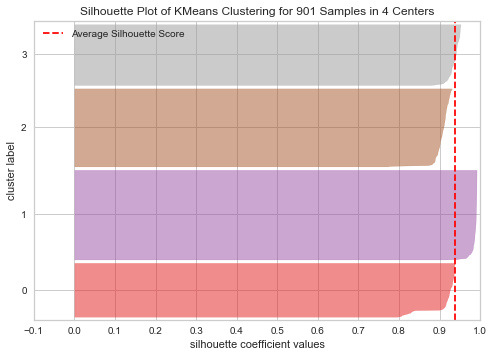

In [114]:
sv = SilhouetteVisualizer(kmeans_pca_minmax)
sv.fit(pca_minmax).show()

In [123]:
clusters = groupby_domains_clustering.copy()
clusters['Cluster'] = kmeans_pca_minmax.labels_
clusters['Geographical zone'] = groupby_domains['Geographical zone'].copy()
clusters['Country'] = groupby_domains['Country'].copy()
clusters['Category'] = groupby_domains['Category'].copy()
clusters['Cluster'] = clusters['Cluster'] + 1
cluster1 = clusters[clusters['Cluster']==1]
cluster2 = clusters[clusters['Cluster']==2]
cluster3 = clusters[clusters['Cluster']==3]
cluster4 = clusters[clusters['Cluster']==4]


clusters.groupby('Cluster').mean()

,Format Fill Rate,CPM,CTR,Category importance,Geographical zone importance
Cluster,,,,,
1,10.21,1.48,0.53,58.61,10.18
2,10.59,1.57,0.69,58.61,53.27
3,8.07,1.41,0.39,3.81,10.95
4,12.35,1.49,0.56,4.36,53.27


In [120]:
display(cluster1.describe(),cluster2.describe(), cluster3.describe(), cluster4.describe()) 


,Format Fill Rate,CPM,CTR,Category importance,Geographical zone importance,Cluster
count,172.00,172.00,172.00,172.00,172.00,172.00
mean,10.21,1.48,0.53,58.61,10.18,1.00
std,13.37,0.36,0.37,0.00,3.76,0.00
min,0.01,0.30,0.00,58.61,0.22,1.00
25%,2.13,1.42,0.26,58.61,8.32,1.00
50%,6.18,1.59,0.45,58.61,11.98,1.00
75%,13.75,1.70,0.68,58.61,13.09,1.00
max,112.28,2.12,2.32,58.61,13.09,1.00


,Format Fill Rate,CPM,CTR,Category importance,Geographical zone importance,Cluster
count,286.00,286.00,286.00,286.00,286.00,286.00
mean,10.59,1.57,0.69,58.61,53.27,2.00
std,9.35,0.26,0.39,0.00,0.00,0.00
min,0.02,0.24,0.01,58.61,53.27,2.00
25%,3.78,1.51,0.43,58.61,53.27,2.00
50%,8.00,1.62,0.65,58.61,53.27,2.00
75%,13.95,1.69,0.87,58.61,53.27,2.00
max,53.97,2.53,3.86,58.61,53.27,2.00


,Format Fill Rate,CPM,CTR,Category importance,Geographical zone importance,Cluster
count,249.00,249.00,249.00,249.00,249.00,249.00
mean,8.07,1.41,0.39,3.81,10.95,3.00
std,10.63,0.44,0.37,2.52,2.12,0.00
min,0.00,0.00,0.00,0.07,1.10,3.00
25%,1.67,1.25,0.12,1.98,10.43,3.00
50%,4.53,1.54,0.29,3.57,11.98,3.00
75%,10.41,1.68,0.57,6.61,13.09,3.00
max,85.34,2.31,1.90,7.63,13.09,3.00


,Format Fill Rate,CPM,CTR,Category importance,Geographical zone importance,Cluster
count,194.00,194.00,194.00,194.00,194.00,194.00
mean,12.35,1.49,0.56,4.36,53.27,4.00
std,10.57,0.31,0.35,2.42,0.00,0.00
min,0.00,0.51,0.00,0.07,53.27,4.00
25%,4.71,1.43,0.31,2.08,53.27,4.00
50%,9.42,1.56,0.50,4.76,53.27,4.00
75%,18.82,1.66,0.76,6.61,53.27,4.00
max,67.94,2.38,2.20,7.63,53.27,4.00


## CLUSTER ANALYSIS

**CLUSTER 1**: 172 domains. All the Domains belong to the News&Portal category. The main geographical zones represented in this cluster are all except South America: Asia(30%), West Europe(25%), and East Europe(19%)
- 79% of  Arabian Domains are in this cluster
- 90% of African Domains are in this cluster
- 45% of Asian Domains are in this cluster
- 40% of West European Domains are in this cluster
- 36% of East European Domains are in this cluster
- 30% of North American Domains are in this cluster


**CLUSTER 2**: 286 domains. All the domains belongs to the News & Portals category, and all of them have the traffic from South America.

**CLUSTER 3**: 249 Domains. The domains belong to all the minority categories, especially Tech&Gaming(23%), Community&Culture(17%), and Sports(14%).
- 70% of North American Domains are in this cluster
- 64% of East European Domains are in this cluster
- 60% of West European Domains are in this cluster
- 55% of Asian Domains are in this cluster
- 21% of  Arabian Domains are in this cluster
- 10% of African Domains are in this cluster


**CLUSTER 4**: 194 domains. All the domains are from South America.  The domains also belong to all the minority categories, especially Community&Culture(19%), Movies&Television (14%) and Sports(14%).


**We can see in this first clustering that the decisive variables have been the Category and the Geographical zone.**
- Cluster1 and Cluster2: These clusters share all the News&Portals Domain. Cluster 2 have only traffic from South America, and in cluster 1 the rest of regions are represented
- Cluster3 and Cluster4 comprehend all the minority categories, Cluster 4 is entirely from South AMerica, and Cluster 3 from the rest of regions.
- After representing some contingency tables, I can confirm that there are no some hide tendency related to the countries. Each country has its domains in two cluster, and the are split in terms of the cluster size

**NOTE**: ***Some of the clustering algorithms generated an slightly better result with k=5 or k=6, but I decide to keep k=4 beacuse it has more "business sense", we can markedly appreciate the differences between clusters***

In [178]:
groupby_domains['Cluster'] = clusters['Cluster']
groupby_domains.to_csv('DATA/Main Clusters before subclustering.csv')
